#### 处理日期格式
1. Handling NaN Values
2. Error Handling for Date Parsing

In [4]:
import pandas as pd
from datetime import datetime

# 读取 CSV 文件
data = pd.read_csv('/home/disk1/red_disk1/test/alldata_20%.csv')

# 处理日期格式，提取月份信息（仅月份，不保存年份）
def extract_month(date_str):
    if pd.isnull(date_str):
        return "Unknown"
    date_str = str(date_str)  # Ensure date_str is a string
    if '-' in date_str:
        parts = date_str.split('-')
        try:
            if len(parts) == 3:  # 2024-06-07 格式
                date_obj = datetime.strptime(date_str, "%Y-%m-%d")
            elif len(parts) == 2:  # 05-20 格式
                date_obj = datetime.strptime(f"2024-{date_str}", "%Y-%m-%d")
            # 只保留月份
            return date_obj.strftime("%m")
        except ValueError:
            return "Unknown"
    return "Unknown"

data['month'] = data['post_date'].apply(extract_month)

# 按月份和类别统计每个类别的数量
month_category_counts = data.groupby(['month', 'nums_category_img']).size().reset_index(name='count')

# 计算每个月份的总数量
month_totals = data.groupby('month').size().reset_index(name='total')

# 合并总数和分类计数
merged_stats = pd.merge(month_category_counts, month_totals, on='month')

# 计算每个类别的比例
merged_stats['proportion'] = merged_stats['count'] / merged_stats['total']

# 保存结果到新的 CSV 文件
merged_stats.to_csv('/home/disk1/red_disk1/test/stastics_20%.csv', index=False)

print("统计结果已保存到新的 CSV 文件中。")


统计结果已保存到新的 CSV 文件中。


In [ ]:
################################################################ 回归任务

In [5]:
# 用于回归任务，拟合具体的占比比例

import pandas as pd

# Read the CSV files
# merged_clustered_labels_path = '/data1/dxw_data/llm/redbook_final/script_next/merged_clustered_labels.csv'
merged_clustered_labels_path = '/home/disk1/red_disk1/test/alldata_20%.csv'
category_proportions_path = '/home/disk1/red_disk1/test/stastics_20%.csv'

merged_df = pd.read_csv(merged_clustered_labels_path)
category_df = pd.read_csv(category_proportions_path)

# Display initial data for debugging
print("Initial merged_df:")
print(merged_df.head())
print("\nInitial category_df:")
print(category_df.head())

# Function to extract month from post_date and add 2 months
def extract_month(date):
    if pd.isnull(date):
        return "Unknown"
    date = str(date)  # Ensure date is a string
    if '-' in date:
        parts = date.split('-')
        try:
            if len(parts) == 3:
                month = int(parts[1])  # Extract month from "YYYY-MM-DD"
            elif len(parts) == 2:
                month = int(parts[0])  # Extract month from "MM-DD"
        except ValueError:
            return "Unknown"
    else:
        try:
            month = int(pd.to_datetime(date).strftime('%m'))
        except ValueError:
            return "Unknown"
    
    # Add 2 to the month and handle wrapping around the year
    month = (month + 2) % 12
    if month == 0:
        month = 12  # Ensure December is represented as 12, not 0
    
    return str(month).zfill(2)

# Apply the function to extract month
merged_df['month'] = merged_df['post_date'].apply(extract_month)

# Ensure the columns used for merging have consistent types and formats
merged_df['nums_category_img'] = merged_df['nums_category_img'].astype(str)
category_df['nums_category_img'] = category_df['nums_category_img'].astype(str)

merged_df['month'] = merged_df['month'].astype(str).str.zfill(2)
category_df['month'] = category_df['month'].astype(str).str.zfill(2)

# Verify the data types and display data for debugging
print("\nData types and sample data after type conversion:")
print(merged_df[['month', 'nums_category_img']].dtypes)
print(merged_df[['month', 'nums_category_img']].head())
print(category_df[['month', 'nums_category_img']].dtypes)
print(category_df[['month', 'nums_category_img']].head())

# Display unique months and category images for further debugging
print("\nUnique months in merged_df:")
print(merged_df['month'].unique())
print("\nUnique months in category_df:")
print(category_df['month'].unique())

print("\nUnique nums_category_img in merged_df:")
print(merged_df['nums_category_img'].unique())
print("\nUnique nums_category_img in category_df:")
print(category_df['nums_category_img'].unique())

# Merge the dataframes on month and nums_category_img
merged_with_proportions_df = pd.merge(merged_df, category_df, how='left', left_on=['month', 'nums_category_img'], right_on=['month', 'nums_category_img'])

# Display the result of the merge for debugging
print("\nMerged DataFrame (first 20 rows):")
print(merged_with_proportions_df.head(20))  # Show more rows to see if the merge is working correctly

# Check rows with NaN values in the merged result
print("\nRows with NaN values in the merged DataFrame:")
print(merged_with_proportions_df[merged_with_proportions_df.isna().any(axis=1)])

# Select the required columns and rename for clarity
merged_with_proportions_df = merged_with_proportions_df[['poster_id', 'post_id', 'nums_category_img', 'post_date', 'post_like', 'post_collect', 'count', 'total', 'proportion']]

# Save the resulting dataframe to a new CSV file
output_path = '/home/disk1/red_disk1/test/after2monthdata_20%.csv'
merged_with_proportions_df.to_csv(output_path, index=False)

print(f"Output saved to {output_path}")


Initial merged_df:
                  poster_id                   post_id  nums_category_img  \
0  5fc059d600000000010049cb  665c4ca60000000005006d3d                  2   
1  56591271e4251d32e78af3af  65703cde000000000901a323                 11   
2  5af3f7d6e8ac2b41762ac4ae  662de56c0000000001031375                 10   
3  5a168ecc11be1037d2c3e342  66226d280000000001006b6a                 17   
4  559a00a7b7ba22339829f6c2  66587a0b000000001303f0cd                  6   

    post_date  post_like  post_collect  post_comments  sentiment  fans_count  \
0  2024-06-02      402.0         104.0           96.0   0.600606    615999.0   
1  2023-12-06      100.0         100.0           10.0   0.989923   1902087.0   
2         NaN        NaN           NaN            NaN        NaN         NaN   
3  2024-04-19     1298.0         239.0           58.0   0.999996    685713.0   
4  2024-05-30      113.0          47.0           15.0   0.984553   1222537.0   

   following_count  total_likes  posts_coun

In [ ]:
################################################################ 分类任务

In [6]:
# 用于分类任务：指定trend，为标签 1，0，-1，比例为各1/3

import pandas as pd

# 读取CSV文件
file_path = '/home/disk1/red_disk1/test/stastics_20%.csv'
df = pd.read_csv(file_path)

# 定义函数来计算trend并打印比例
def calculate_trend(df):
    p33_proportion = df['proportion'].quantile(0.3333)
    p66_proportion = df['proportion'].quantile(0.6667)
    
    def get_trend(proportion):
        if proportion > p66_proportion:
            return 1
        elif proportion < p33_proportion:
            return -1
        else:
            return 0
    
    df['trend'] = df['proportion'].apply(get_trend)
    
    # 计算并打印比例
    trend_counts = df['trend'].value_counts(normalize=True)
    total_counts = df['trend'].value_counts()
    print(f"Month: {df['month'].iloc[0]}")
    print(f"Total counts: 1: {total_counts.get(1, 0)}, 0: {total_counts.get(0, 0)}, -1: {total_counts.get(-1, 0)}")
    print(f"Proportion: 1: {trend_counts.get(1, 0):.2%}, 0: {trend_counts.get(0, 0):.2%}, -1: {trend_counts.get(-1, 0):.2%}")
    print()
    
    return df

# 对每个月的数据分别计算trend
df = df.groupby('month').apply(calculate_trend)

# 保存结果到新的CSV文件
output_file_path = '/home/disk1/red_disk1/test/stastics_20%_with_trend.csv'
df.to_csv(output_file_path, index=False)

print("Trend calculation and CSV export completed.")


Month: 01
Total counts: 1: 1, 0: 4, -1: 0
Proportion: 1: 20.00%, 0: 80.00%, -1: 0.00%

Month: 02
Total counts: 1: 0, 0: 2, -1: 0
Proportion: 1: 0.00%, 0: 100.00%, -1: 0.00%

Month: 03
Total counts: 1: 0, 0: 4, -1: 0
Proportion: 1: 0.00%, 0: 100.00%, -1: 0.00%

Month: 04
Total counts: 1: 5, 0: 8, -1: 3
Proportion: 1: 31.25%, 0: 50.00%, -1: 18.75%

Month: 05
Total counts: 1: 6, 0: 7, -1: 5
Proportion: 1: 33.33%, 0: 38.89%, -1: 27.78%

Month: 06
Total counts: 1: 4, 0: 4, -1: 4
Proportion: 1: 33.33%, 0: 33.33%, -1: 33.33%

Month: 07
Total counts: 1: 0, 0: 1, -1: 0
Proportion: 1: 0.00%, 0: 100.00%, -1: 0.00%

Month: 08
Total counts: 1: 0, 0: 1, -1: 0
Proportion: 1: 0.00%, 0: 100.00%, -1: 0.00%

Month: 10
Total counts: 1: 0, 0: 1, -1: 0
Proportion: 1: 0.00%, 0: 100.00%, -1: 0.00%

Month: 11
Total counts: 1: 1, 0: 0, -1: 1
Proportion: 1: 50.00%, 0: 0.00%, -1: 50.00%

Month: 12
Total counts: 1: 1, 0: 3, -1: 0
Proportion: 1: 25.00%, 0: 75.00%, -1: 0.00%

Month: Unknown
Total counts: 1: 5, 0: 4,

visualize the proportion of labels using a histogram

In [8]:
# 用于分类任务：指定trend，为标签 1，0，-1，对应火不火

import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV files
# merged_clustered_labels_path = '/data1/dxw_data/llm/redbook_final/script_next/merged_clustered_labels.csv'
merged_clustered_labels_path = '/home/disk1/red_disk1/test/alldata_20%.csv'
category_proportions_path = '/home/disk1/red_disk1/test/stastics_20%_with_trend.csv'

merged_df = pd.read_csv(merged_clustered_labels_path)
category_df = pd.read_csv(category_proportions_path)

# Display initial data for debugging
print("Initial merged_df:")
print(merged_df.head())
print("\nInitial category_df:")
print(category_df.head())

# Function to extract month from post_date and add 2 months
def extract_month(date):
    if pd.isnull(date):
        return "Unknown"
    date = str(date)  # Ensure date is a string
    if '-' in date:
        parts = date.split('-')
        try:
            if len(parts) == 3:
                month = int(parts[1])  # Extract month from "YYYY-MM-DD"
            elif len(parts) == 2:
                month = int(parts[0])  # Extract month from "MM-DD"
        except ValueError:
            return "Unknown"
    else:
        try:
            month = int(pd.to_datetime(date).strftime('%m'))
        except ValueError:
            return "Unknown"
    
    # Add 2 to the month and handle wrapping around the year
    month = (month + 2) % 12
    if month == 0:
        month = 12  # Ensure December is represented as 12, not 0
    
    return str(month).zfill(2)

# Apply the function to extract month
merged_df['month'] = merged_df['post_date'].apply(extract_month)

# Ensure the columns used for merging have consistent types and formats
merged_df['nums_category_img'] = merged_df['nums_category_img'].astype(str)
category_df['nums_category_img'] = category_df['nums_category_img'].astype(str)

merged_df['month'] = merged_df['month'].astype(str).str.zfill(2)
category_df['month'] = category_df['month'].astype(str).str.zfill(2)

# Verify the data types and display data for debugging
print("\nData types and sample data after type conversion:")
print(merged_df[['month', 'nums_category_img']].dtypes)
print(merged_df[['month', 'nums_category_img']].head())
print(category_df[['month', 'nums_category_img']].dtypes)
print(category_df[['month', 'nums_category_img']].head())

# Display unique months and category images for further debugging
print("\nUnique months in merged_df:")
print(merged_df['month'].unique())
print("\nUnique months in category_df:")
print(category_df['month'].unique())

print("\nUnique nums_category_img in merged_df:")
print(merged_df['nums_category_img'].unique())
print("\nUnique nums_category_img in category_df:")
print(category_df['nums_category_img'].unique())

# Merge the dataframes on month and nums_category_img
merged_with_proportions_df = pd.merge(merged_df, category_df, how='left', left_on=['month', 'nums_category_img'], right_on=['month', 'nums_category_img'])

# Display the result of the merge for debugging
print("\nMerged DataFrame (first 20 rows):")
print(merged_with_proportions_df.head(20))  # Show more rows to see if the merge is working correctly

# Check rows with NaN values in the merged result
print("\nRows with NaN values in the merged DataFrame:")
print(merged_with_proportions_df[merged_with_proportions_df.isna().any(axis=1)])

# Select the required columns and rename for clarity
merged_with_proportions_df = merged_with_proportions_df[['poster_id', 'post_id', 'nums_category_img', 'post_date', 'post_like', 'post_collect', 'count', 'total', 'proportion','trend']]

# Save the resulting dataframe to a new CSV file
output_path = '/home/disk1/red_disk1/test/after2monthdata_20%_with_trend.csv'
merged_with_proportions_df.to_csv(output_path, index=False)

print(f"Output saved to {output_path}")


Initial merged_df:
                  poster_id                   post_id  nums_category_img  \
0  5fc059d600000000010049cb  665c4ca60000000005006d3d                  2   
1  56591271e4251d32e78af3af  65703cde000000000901a323                 11   
2  5af3f7d6e8ac2b41762ac4ae  662de56c0000000001031375                 10   
3  5a168ecc11be1037d2c3e342  66226d280000000001006b6a                 17   
4  559a00a7b7ba22339829f6c2  66587a0b000000001303f0cd                  6   

    post_date  post_like  post_collect  post_comments  sentiment  fans_count  \
0  2024-06-02      402.0         104.0           96.0   0.600606    615999.0   
1  2023-12-06      100.0         100.0           10.0   0.989923   1902087.0   
2         NaN        NaN           NaN            NaN        NaN         NaN   
3  2024-04-19     1298.0         239.0           58.0   0.999996    685713.0   
4  2024-05-30      113.0          47.0           15.0   0.984553   1222537.0   

   following_count  total_likes  posts_coun

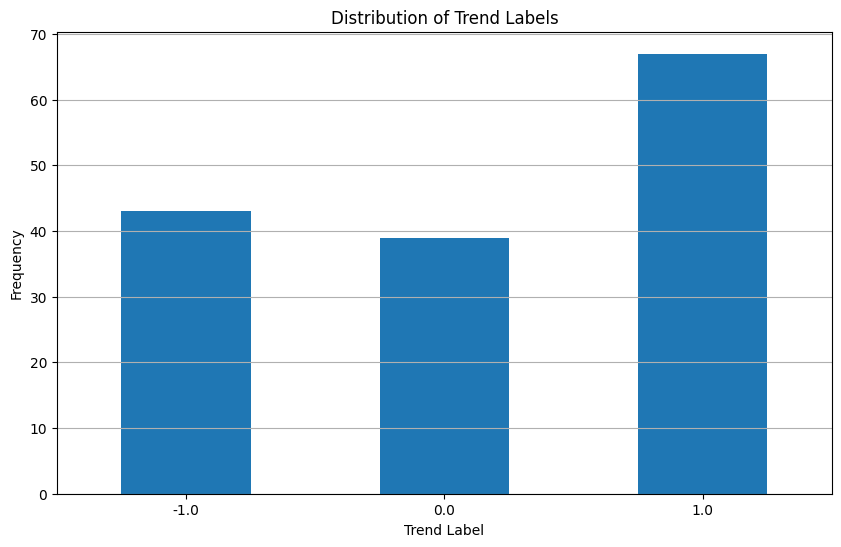

In [9]:
# Visualize the proportion of labels using a histogram
plt.figure(figsize=(10, 6))
merged_with_proportions_df['trend'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Trend Label')
plt.ylabel('Frequency')
plt.title('Distribution of Trend Labels')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

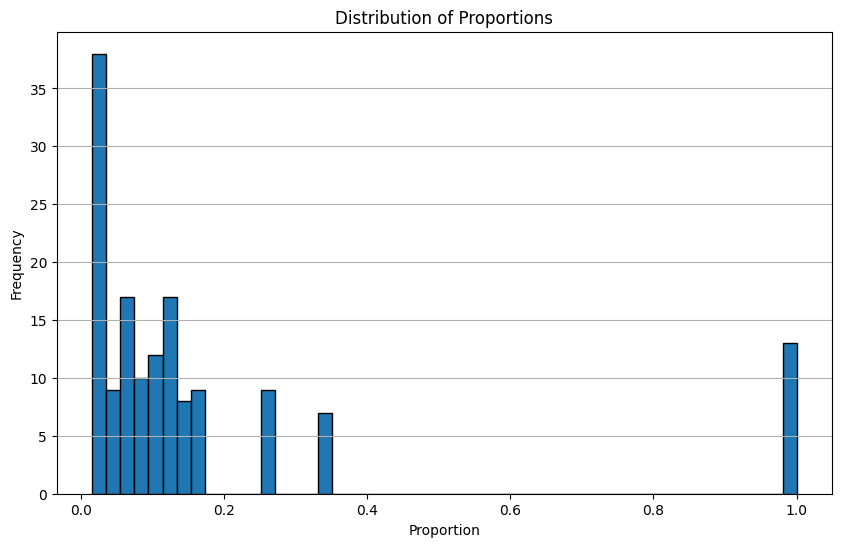

In [10]:
# Visualize the 'proportion' column using a histogram
plt.figure(figsize=(10, 6))
merged_with_proportions_df['proportion'].plot(kind='hist', bins=50, edgecolor='black')
plt.xlabel('Proportion')
plt.ylabel('Frequency')
plt.title('Distribution of Proportions')
plt.grid(axis='y')
plt.show()
